<a href="https://colab.research.google.com/github/AilingLiu/Survival_analysis/blob/master/Use_Survival_Analysis_to_Estimate_Customer_Lifetime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

We will be using Lifetime module to estimate average customer lifetime.

Steps:
* Preprocessing the data
* Use Kaplan Meier estimator to estimate the average customer lifetime
* Average Customer lifetime value by contract type
* Average Customer lifetime value by gender

In another notebook in the same repository, I would analyze customer churn rate with survival analysis.

The data will be Telecome Churn Data from [kaggle](https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction/data).

In [5]:
url = 'https://raw.githubusercontent.com/AilingLiu/Survival_analysis/master/Data/Telco-Customer-Churn.csv'
df = pd.read_csv(url, sep=',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Take a look of the data

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

7043 cases, and 21 coluns. None of the columns appear to have missing values. 

Out interest of event is 'churn', which leads to the estimation of lifetime value before customer churn.

In [0]:
pd.DataFrame({'Number_of_Customer': df['Contract'].value_counts(),
              'pct': df['Contract'].value_counts(normalize=True).round(4)*100})

,Number_of_Customer,pct
Month-to-month,3875,55.02
Two year,1695,24.07
One year,1473,20.91


we have three contract types here. Half of the customers have `Month-to-month` contract type; the second popular contract type is `Two year`, the least popular contract is `One year`.

In [0]:
df.groupby(['Contract'])['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
Contract,,,,,,,,
Month-to-month,3875.0,66.398490,26.926599,18.75,45.850,73.25,88.875,117.45
One year,1473.0,65.048608,31.840539,18.25,26.900,68.75,94.800,118.60
Two year,1695.0,60.770413,34.678865,18.40,24.025,64.35,90.450,118.75


Apparently, the monthly charges are not all the same within the same contract among customers. Let's see if the same customer pay different monthly rate within the contract life.

In [0]:
df.groupby(['customerID'])['MonthlyCharges'].nunique().describe()

count    7043.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: MonthlyCharges, dtype: float64

here it shows each customer pays the same monthly rate within their contract.

In [0]:
any(df.groupby(['customerID'])['Contract'].apply(lambda sub: len(sub) > 1))

False

Here it shows each customer has only one type of contract.


Let's check a few factors related to churn:

* which gender
* which contract
* what level of monthly rate

## CLV by gender

In [0]:
churnbygender = pd.crosstab(columns=df['Churn'], index=df['gender'], margins=True, margins_name='Total')
display(churnbygender)


Churn,No,Yes,Total
gender,,,
Female,2549,939,3488
Male,2625,930,3555
Total,5174,1869,7043


In [0]:
churnbygenderP = pd.crosstab(columns=df['Churn'], index=df['gender'], margins=True, margins_name='Total', normalize='index').round(2)
display(churnbygenderP)

Churn,No,Yes
gender,,
Female,0.73,0.27
Male,0.74,0.26
Total,0.73,0.27


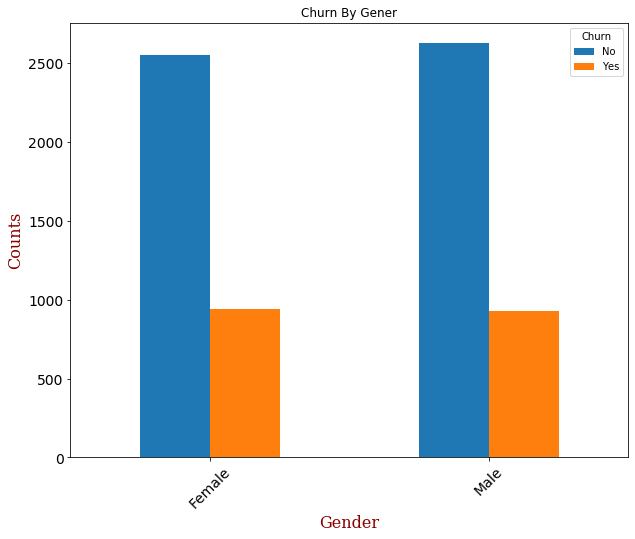

In [0]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

tabl = df.groupby(['gender'])['Churn'].value_counts().unstack()

ax = tabl.plot(kind='bar', 
                        figsize=(10, 8), 
                        title='Churn By Gener',
                        rot=45)
ax.set_ylabel('Counts', fontdict=font)
ax.set_xlabel('Gender', fontdict=font)
plt.show()

The churn rate between gender appears to be very similar. We will use z test to check its significance.

In [0]:
from statsmodels.stats.proportion import proportions_ztest
x_success = churnbygender.iloc[:2, 0]
n_total = churnbygender.iloc[:2, -1]
z_val, p_val = proportions_ztest(count=x_success, nobs=n_total, alternative='two-sided')
print(p_val)

0.4698339411426522


P value is greater than conventional 0.05. We do not have sufficient proof that male and female have different churn rate.

## CLV by contract

In [0]:
tem = df.groupby(['Churn'])['Contract'].value_counts(normalize=True).unstack()\
.round(3)
display(tem)

Contract,Month-to-month,One year,Two year
Churn,,,
No,0.429,0.253,0.318
Yes,0.886,0.089,0.026


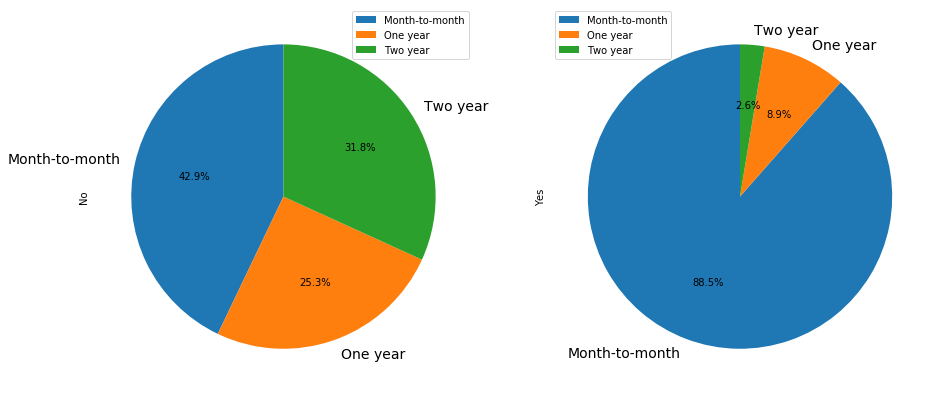

In [0]:
ax = tem.T.plot(kind='pie',
         subplots=True,
         figsize=(15, 7),
        startangle=90,
        autopct='%0.1f%%')

plt.show()

88.5% of customers who churned are those with monthly contract. The remains, 11.5%, churned customers are from annual contracts. It makes sense as long term contract customers have been tied to contract.

## CLV by monthly rate

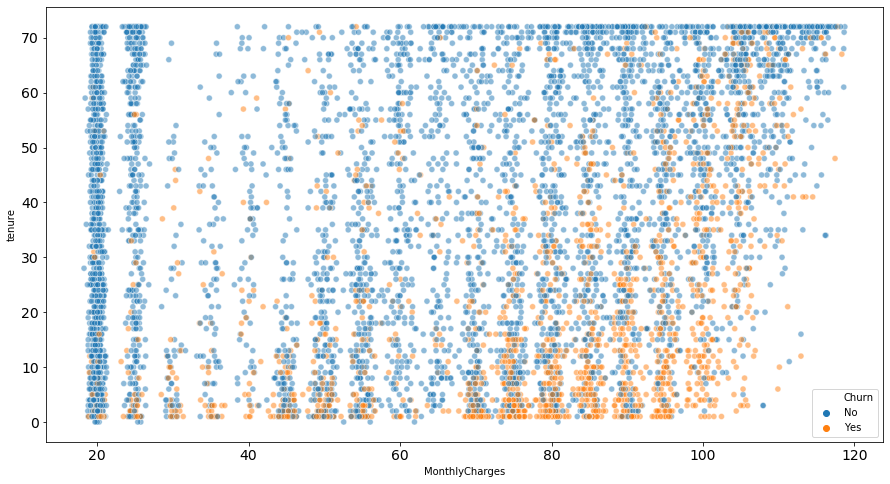

In [0]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.scatterplot(y='tenure', x='MonthlyCharges', hue='Churn',data=df, alpha=0.5)
plt.show()

Above graphs shows the expensive monthly charges see a lower tenure on average, leading to higher churned percentage.


# Estimating the survival function using Kaplan-Meier

In [0]:
pip install lifelines

In [0]:
# convert the factor levels to number
df['ChurnInd'] = np.where(df['Churn']=='Yes', 1, 0)

In [8]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = df["tenure"]
E = df["ChurnInd"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

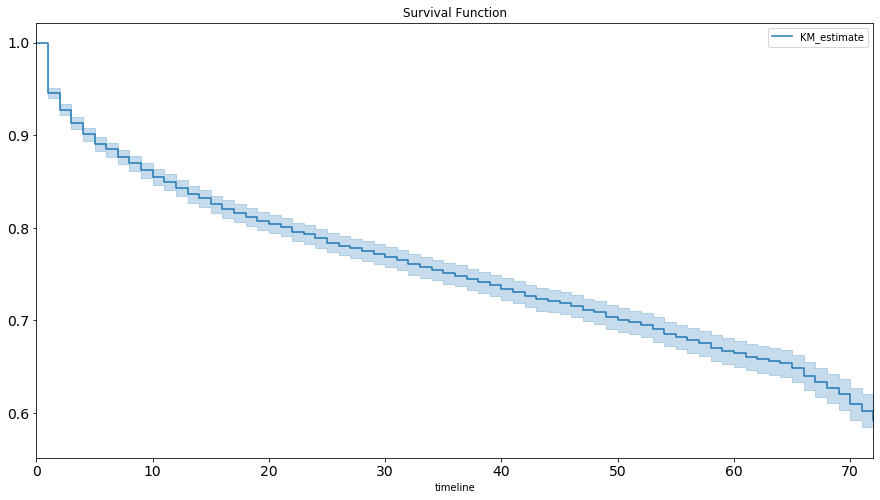

In [9]:
plt.figure(figsize=(15, 8))
ax = kmf.plot_survival_function()
plt.title('Survival Function')
plt.show()

Withouth segmenting lifetime by contract type, over half of the customers are active at 70 (months). Let's split the survival function to check by contract group. 

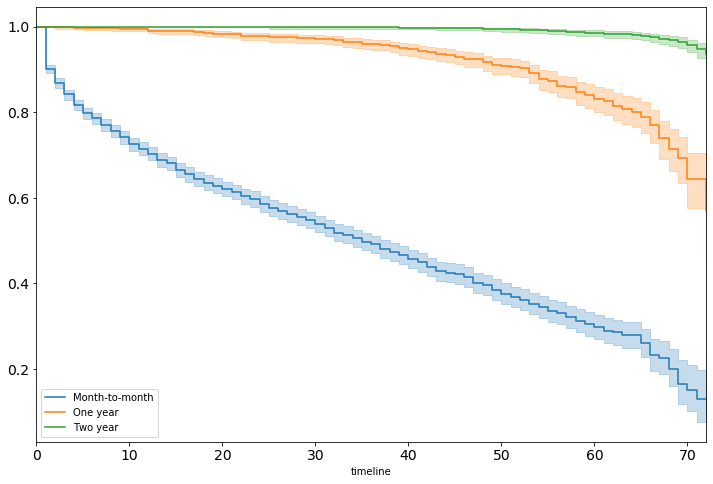

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
kmf = KaplanMeierFitter()

for name, df_ in df[['Contract', 'ChurnInd', 'tenure']].groupby('Contract'):
  kmf.fit(df_['tenure'], df_['ChurnInd'], label=name)
  ax = kmf.plot(ax=ax, ci_show=True)

It is expected that annual contracts exist longer than monthly contract. The median of any annual contract, either one year, or two year, are at least twice as large as a monthly contract. The tail of all these three type of contracts are not close to 0, because the data covers less than 70 months(about 5.8 years) where there is still a significant proportion of customer alive. Nonetheless, the tail of a monthl contract lifetime is quite close to 0. If a yearly contract cusstomer made it to 70 months mark, she/he still have a long life ahead. Meanwhile, a monthly contract customer rarely makes it past 70 months, and then have a very short lifetie past that.

## The expected customer lifetime value (monthly contract)

In [0]:
# month to month contract
ix = df['Contract'] == 'Month-to-month'
kmf.fit(df.loc[ix, 'tenure'], df.loc[ix, 'ChurnInd'])
kmf.median_survival_time_

35.0

The average(median) lifetime value for monthly contract is 35 months, provided the maximum customer live is 70 months. For the other two types of annual contract, we have insufficient data (data after 70 months) to estimate the average lifetime value.

## The expected customer lifetime value (by gender)

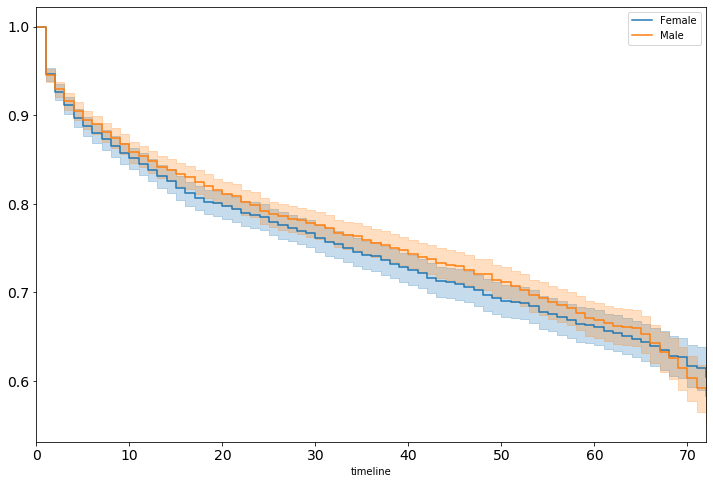

In [13]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

for name, df_ in df[['gender', 'tenure', 'ChurnInd']].groupby('gender'):
  kmf.fit(df_['tenure'], df_['ChurnInd'], label=name)
  ax = kmf.plot(ax=ax, ci_show=True)

From the graph, it looks like the survival curve between Female and Male is very similar. Let's conduct a log rank test to evaluate if its true.


* $H_0$: The two survival curves are identical (or S1t = S2t) versus 
* $H_1$: The two survival curves are not identical (or S1t ≠ S2t, at any time t) (α=0.05).

In [14]:
from lifelines.statistics import logrank_test

male = df['gender'] == 'Male'
T = df['tenure']
E = df['ChurnInd']
results = logrank_test(T[male], T[~male], E[male], E[~male], alpha=.99)

results.print_summary()

The p value is 0.47, greater than conventional 0.05. In this case, we cannot reject null hypothesis, and rule that that male and female has similar "death" generation process. In this case, the expected lifetime value of monthly contract makes no difference between genders, hence it remains to be 35 months.